# <u> Implementing the Perceptron Algorithm </u>

## Abstract

For this blog post I implemented the perceptron algorithm. I then ran several experiments to visualize the changes to my model each iteration and see the improvement of my loss. I investigated how the perceptron implementation changed when given linearly separable data vs not and 2 dimension vs more dimensional data. Through these steps I learned the perceptron algorithm works and how that functionality can change to accommodate different data. Ultimately, I learned that the perceptron algorithm works well to address many different data forms by continuously updating our model based on misclassified points.

Link to source code (perceptron.py): 

In perceptron.py I implemented 5 functions: score, predict, loss, grad, and step. Here I will go through to briefly explain each function.

1. score:
Calculate the score by taking the cross product of the data input and the weights.

2. predict:
Calculates y_hat where y_hat is 1 when the score is greater than or equal to 0, and 0 otherwise.

3. loss:
Finds loss by calculating mean of misclassified data points.

4. grad:
Calculates score. If misclassified, returns gradient of cross product of data input and output $$\mathbb{1}\left[s_i y_{i} < 0 \right] y_{i} \mathbf{x}_{i}$$ Otherwise, return 0 gradient.

5. step:
Calls and returns loss function. Adds gradient from grad function to model.

In [33]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
from perceptron_minibatch import Perceptron_mini, PerceptronOptimizer_mini

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implement perceptron on linearly separable data

First, I used data from warmup to create a plot of linearly separable data.

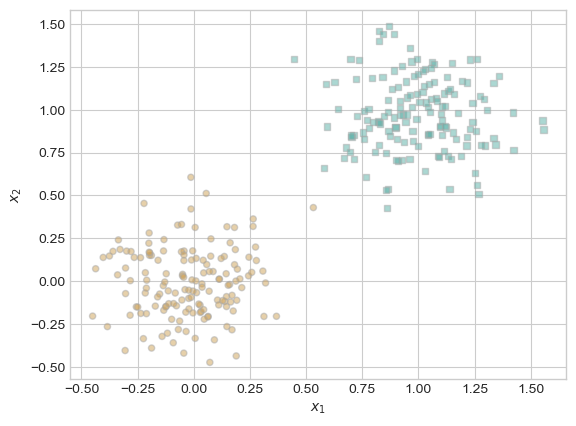

In [7]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

def plot_perceptron_data(X, y, ax):
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

See if perceptron.py code is functional by run the “minimal training loop” code from this section of the notes and eventually achieve loss = 0 on linearly separable data.

In [8]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

Then I showed visualizations of the data, the separating line, and the evolution of the loss function during training.

I copied the graph from notes in class to show the change of the loss in iterations of the perceptron algorithm.

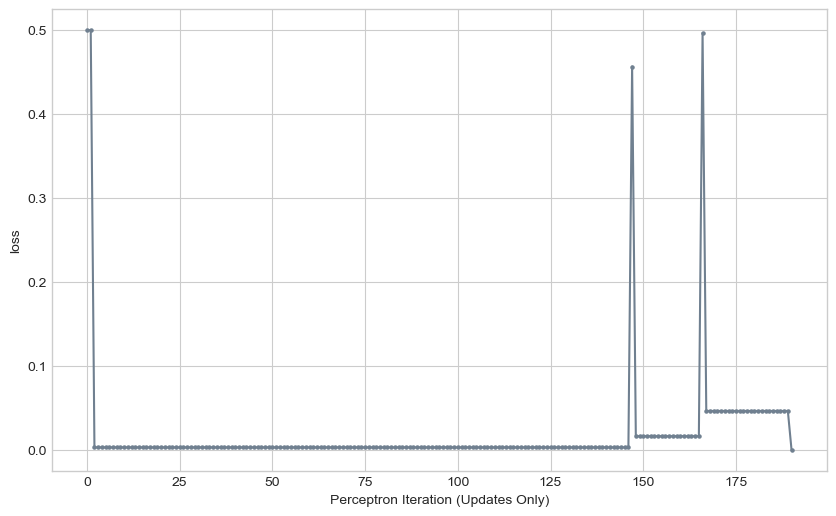

In [9]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))


plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey", s=5)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

This shows that the loss gradually decreases over the iterations and eventually reaches 0 (possible as the data is linearly separable).

I then used some of the code from class notes again to rerun and visualize how the algorithm updates the weights over iterations.

In [10]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

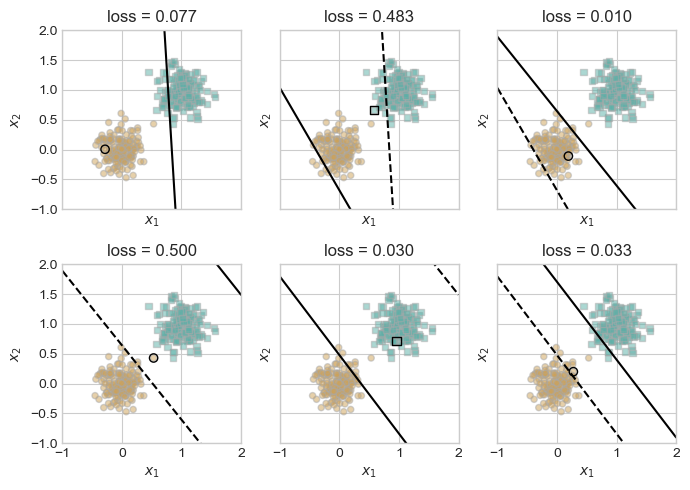

In [25]:
from perceptron import Perceptron, PerceptronOptimizer
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    local_loss = opt.step(x_i, y_i)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if (local_loss > 0):
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        
        if(current_ax < 5):
            current_ax += 1
        else:
            break
        
plt.tight_layout()

This visualization shows how the perceptron updates the predictions every time the loss is greater than 0.

## Implement perceptron on data that is not linearly separable

I changed class notes code to include 50 points that overlap the existing classes. This will mean that the data is not necessarily linearly separable like the data before.

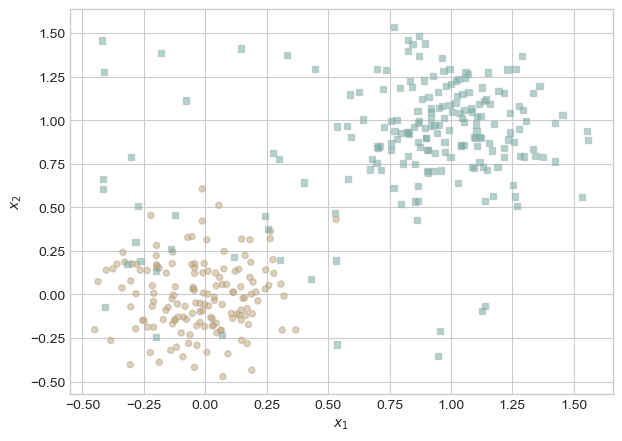

In [26]:
import torch
from matplotlib import pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
torch.manual_seed(1234)

def perceptron_data_overlap(n_points=300, noise=0.2, p_dims=2, overlap_points=50):
   
    y = torch.arange(n_points) >= int(n_points / 2)
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # Add overlapping points within the range of existing points
    overlap_X = torch.rand(overlap_points, p_dims) * (X.max() - X.min()) + X.min()
    overlap_X = torch.cat((overlap_X, torch.ones((overlap_X.shape[0], 1))), 1)
    X = torch.cat((X, overlap_X), dim=0)

    # Convert y from {0, 1} to {-1, 1}
    y = torch.cat((2 * y - 1, torch.ones(overlap_points, dtype=torch.long)))  # Label the overlapping points as class 1

    return X, y

def plot_perceptron_data_overlap(X, y, ax):
    targets = [-1, 1]
    markers = ["o", ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix, 0], X[ix, 1], s=20, c=y[ix], facecolors="none", edgecolors="darkgrey", cmap="BrBG", vmin=-2, vmax=2, alpha=0.5, marker=markers[i])
    ax.set(xlabel=r"$x_1$", ylabel=r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data_overlap()
plot_perceptron_data_overlap(X, y, ax)
plt.show()

Next, I reran the perceptron algorithm. The difference with not linearly separable data is that I cannot run the algorithm until the loss is 0 as it will never be 0 for this data. Instead, I ran the data for 1000 iterations based on Pr.Chodrow's advice in the blog post description. I also including code to visualize model updates.

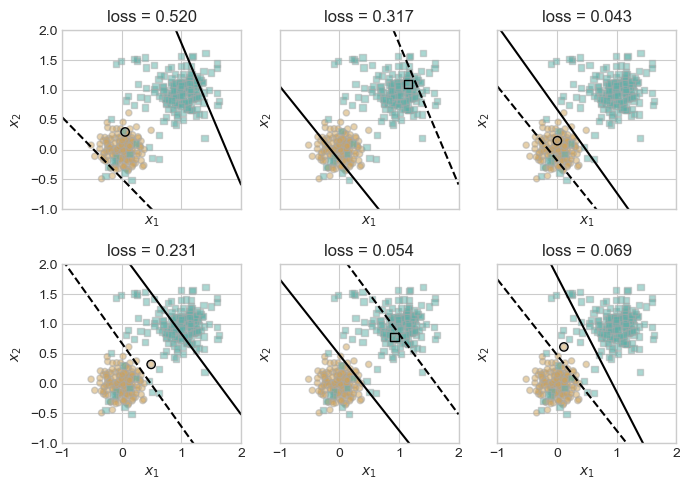

In [28]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
X, y = perceptron_data_overlap()
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

for index in range(0, 1000):
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    local_loss = opt.step(x_i, y_i)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if (local_loss > 0):
        plot_perceptron_data_overlap(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        
        if(current_ax < 5):
            current_ax += 1
        else:
            break
plt.tight_layout()

I then reran code to show the updates of the loss.

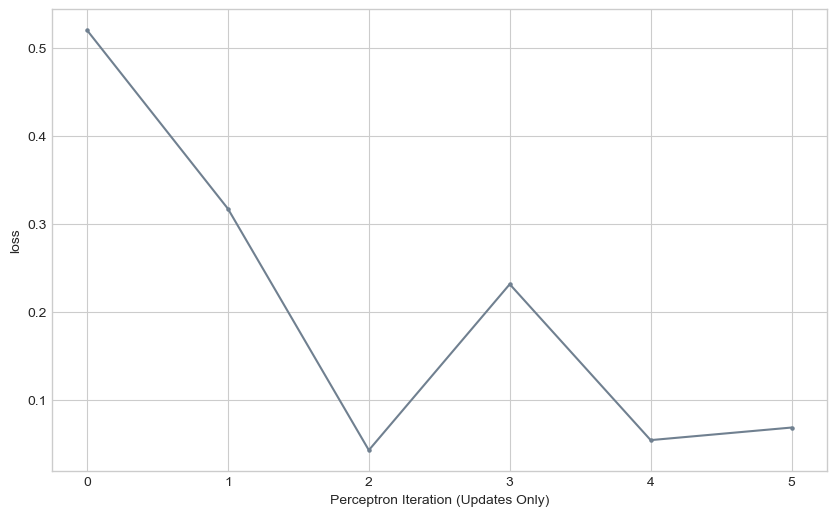

In [29]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))


plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey", s=5)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Here we can see that the loss decreases over time but does not reach 0 like in the linearly separable case.

## Implement perceptron on data with more than 2 dimensions

The only difference here is that I created data with more than 5 dimensions.

In [30]:
X, y = perceptron_data_overlap(n_points = 300, noise = 0.2, p_dims = 5)

I ran the perceptron algorithm for 1000 iterations, without knowing if the data is linearly separable.

In [31]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec_dimen = []

n = X.size()[0]

for index in range(0, 1000):
    
    loss = p.loss(X, y) 
    loss_vec_dimen.append(loss)
    
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

I then visualized the loss over time.

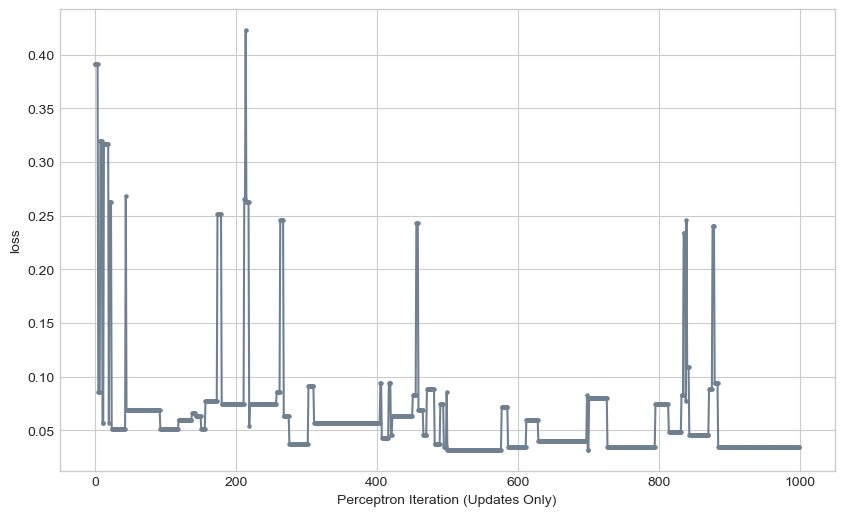

In [32]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))


plt.plot(loss_vec_dimen, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_dimen)), loss_vec_dimen, color = "slategrey", s=5)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Because the visualization of the loss vector shows that data never fully reaches a loss of 0 after 1000 iterations, we can conclude that the data is probably not linearly separable. 

## Implement Minibatch

1. modify your perceptron.grad() method so that it accepts a submatrix of the feature matrix X of size kxp

Update my main training loop

## Minibatch Perceptron Experiments

Please perform experiments and create visualizations to demonstrate the following:

When k = 1, minibatch perceptron performs similarly to regular perceptron.

In [ ]:
X, y = perceptron_data(n_points = 300, noise = 0.2)

In [43]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron_mini()
opt = PerceptronOptimizer_mini(p)

loss = 1.0

# for keeping track of loss values
loss_vec_mini = []

n = X.size()[0]

for index in range(0, 1000):
    
    loss = p.loss(X, y) 
    loss_vec_mini.append(loss)
    
    # get a random submatrix of the feature matrix X and target vector y to implement minibatch
    k = 3
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    # print(f"{y_i=}")

    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

r=tensor([ 0.0051,  0.0127, -0.0022, -0.0033,  0.0045, -0.0333])
r=tensor([0., 0., 0., 0., 0., 0.])
r=tensor([-0.0050,  0.0059, -0.0048, -0.0149, -0.0022, -0.0667])
r=tensor([ 0.0048, -0.0059,  0.0032, -0.0052,  0.0026, -0.0333])
r=tensor([ 0.0096,  0.0075,  0.0044, -0.0102,  0.0017, -0.0667])
r=tensor([ 0.0023, -0.0025, -0.0052, -0.0008,  0.0070, -0.0667])
r=tensor([ 0.0020,  0.0038, -0.0050, -0.0118, -0.0028, -0.0333])
r=tensor([0., 0., 0., 0., 0., 0.])
r=tensor([0., 0., 0., 0., 0., 0.])
r=tensor([0., 0., 0., 0., 0., 0.])
r=tensor([ 0.0011,  0.0085, -0.0005, -0.0073, -0.0034, -0.0667])
r=tensor([ 0.0064,  0.0015,  0.0007, -0.0080, -0.0296, -0.0333])
r=tensor([ 0.0064,  0.0015,  0.0007, -0.0080, -0.0296, -0.0333])
r=tensor([0., 0., 0., 0., 0., 0.])
r=tensor([0., 0., 0., 0., 0., 0.])
r=tensor([ 0.0180,  0.0216, -0.0234, -0.0082, -0.0059, -0.0333])
r=tensor([0., 0., 0., 0., 0., 0.])
r=tensor([-1.1892e-02, -4.0852e-05,  6.0027e-03, -1.3593e-04, -4.7515e-03,
        -3.3333e-02])
r=tensor

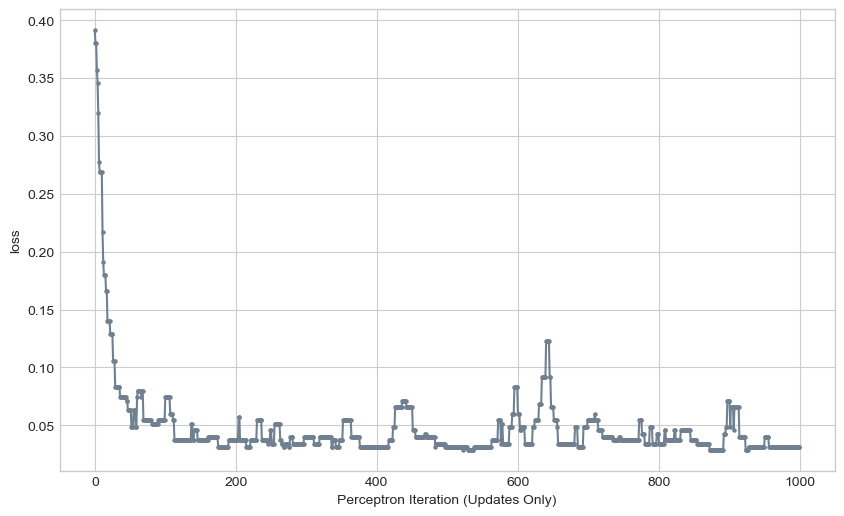

In [44]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))


plt.plot(loss_vec_mini, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_mini)), loss_vec_mini, color = "slategrey", s=5)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

## Discussion Question

### What is the runtime complexity of a single iteration of the perceptron algorithm? Does the runtime complexity of a single iteration depend on the number of data points n? What about the number of features p?

For a single iteration of the perceptron algorithm the dot product is taken between w and one row of the feature matrix X, as each row represents a data point. The size of the row of the feature matrix is p, the number of dimensions of the data. Therefore a single iteration's runtime is O(p). 

### If you implemented minibatch perceptron, what is the runtime complexity of a single iteration of the minibatch perceptron algorithm?

ADD SOMETHING ABOUT MINIBATCH IF I IMPLEMENT

## Conclusion

ADD SOMETHING ABOUT MINIBATCH IF I IMPLEMENT

Through this blog posts I learned many important lessons in Machine Learning and computing in general. Firstly, I was able to implement the perceptron algorithm and understand the steps that go into updating a machine learning model. Through my experiments I was able to validate that my implementation was correct. Through experimentation I learned how to analyze the updates of perceptron and see how the algorithm functions on different data. I was able to develop my abilities to visualize data and use those visualizations to understand both the input data and the algorithm itself. Ultimately, a was able to successfully implement and use the perceptron algorithm for linearly separable data, non-linearly separable data, and data with more than 2 dimensions.